In [1]:
#%matplotlib inline
from matplotlib import pyplot as plt
import xarray as xr
import numpy as np

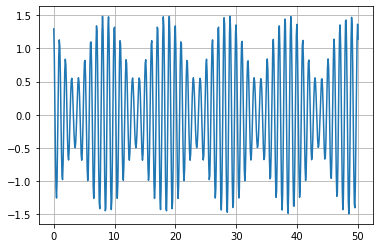

In [2]:
### define time
t_max = 50
dt = .09
tt = np.arange(0, t_max+dt, dt)

### sum of harmonics
om_1 = 2*np.pi/1.
om_2 = om_1 * 1.1

amp_1 = 1.
amp_2 = .5

phi_1 = 0
phi_2 = .3*np.pi

sig1 = amp_1 * np.exp(-1.j*(om_1*tt+phi_1))
sig2 = amp_2 * np.exp(-1.j*(om_2*tt+phi_2))
sig = ( amp_1 * np.exp(-1.j*(om_1*tt+phi_1)) + amp_2 * np.exp(-1.j*(om_2*tt+phi_2)) ).real

### Plot
plt.figure()
plt.plot(tt, sig)
plt.grid(True)

bornes, T, eps, t0: 0.30000000000000004 2.7 2.0 0.1 1.5
bornes, T, eps, t0: 0.30000000000000004 2.7 2.0 0.0 1.5
bornes, T, eps, t0: 0.30000000000000004 2.7 2.0 0.1 1.5


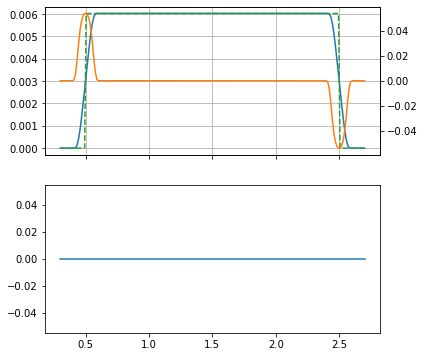

In [3]:
### define a window function

def planck_taper_ext(t, T=1., eps=.1, t0=0., normalized=True):
    """ planck taper window with transient centered at window length 
    quick and dirty implementation. Window is  centered
    planck taper with standard definition: transient centered at -T(.5-eps), T*(.5-eps). 
    extending time to T/(1-eps) make the interval between transient center equals T.
    return normalized window such that sum is 1 """
    print("bornes, T, eps, t0:", t.min(), t.max(), T, eps, t0)
    if eps>=.5:
        raise ValueError("need eps<.5. Passed value is {:.2f}".format(eps))
    t = (t-t0)/T*(1.-eps) # use coordinate mapping: stretching 
    t1, t4 = -.5, .5
    win = np.where((t>t1) * (t<t4), 1., 0.)
    if eps > 0.:
        t2 = (eps-.5)
        t3 = (.5-eps)
        z_t = np.where(t<0., (t2-t1)/(t-t1) + (t2-t1)/(t-t2), (t3-t4)/(t-t3) + (t3-t4)/(t-t4))
        win = np.where((t<t2) + (t>t3), win/(np.exp(z_t)+1.), win)

    if normalized and win.max()>0.:
        win /= win.sum()
        
    return win

### test it
Lwin, eps, t0 = 2., .1, 1.5
t_t = t0 + np.linspace(-Lwin*(.5+eps), Lwin*(.5+eps),200)
yy = planck_taper_ext(t_t, Lwin, eps, t0)

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(6,6))
ax = axs[0]
ax.plot(t_t, yy)
ax.plot(t_t, planck_taper_ext(t_t, Lwin, 0., t0), linestyle="--", color="C2")
ax.grid(True)
bx = ax.twinx()
bx.plot(t_t, np.gradient(yy, t_t), color="C1")

ax = axs[1] # this must be 0
yy = planck_taper_ext(t_t, Lwin, eps, t0, normalized=False)
ax.plot(t_t, (yy>.5)-np.where( (t_t>t0-Lwin/2.) * (t_t<t0+Lwin/2.), 1., 0.) )

l : 13
bornes, T, eps, t0: <xarray.DataArray 'time' ()>
array(0.) <xarray.DataArray 'time' ()>
array(1.08) 0.9523809523809523 0.25 <xarray.DataArray 'time' ()>
array(0.54)


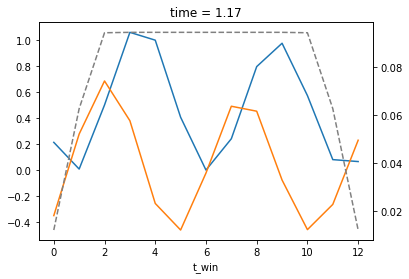

In [4]:
# """ HARMONIC EXTRACTION """
### Préparation dataset
da = xr.DataArray(data = sig, dims =("time"), coords = {"time" : tt})

### Define periods and stuff
omega = 0.5*(om_1 + om_2)
f = omega / 2./np.pi
eps_win = .25 # relative length (in periods) of transient for time window
n_per = 1 # number of targeted periods / window
n_win = int(round( ((n_per+eps_win))/f/dt))
print("l :", n_win)

### harmonic extraction
# create rolling object and construt: window index is a new dim, "t_win"
da_rol = (da*xr.ufuncs.exp(-1.j*omega*da.time)).rolling(time=n_win, center=True).construct("t_win")
win = xr.DataArray(data=planck_taper_ext(da.time[:n_win], T=n_per/f, eps=eps_win, t0=da.time[:n_win].mean()), 
                   dims=("t_win"))
da_harmo_win = (da_rol*win).sum("t_win")

da_rol.isel(time=n_win).real.plot()
da_rol.isel(time=n_win).imag.plot()
bx = plt.gca().twinx()
win.plot(ax=bx, linestyle="--", color="grey")

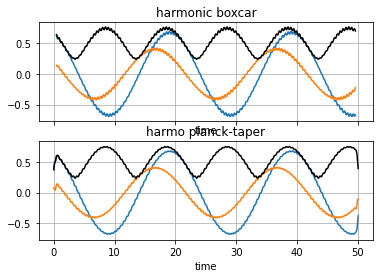

In [5]:
### plot, comparing with same harmonic extraction without windowing
n_win = int(round( n_per/f/dt ) )
da_harmo_nowin = (da*xr.ufuncs.exp(-1.j*omega*da.time)).rolling(time=n_win, center=True).mean()

fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)
ax = axs[0]
da_harmo_nowin.real.plot(ax=ax)
da_harmo_nowin.imag.plot(ax=ax)
abs(da_harmo_nowin).plot(ax=ax, color="k")
ax.set_title("harmonic boxcar")

ax = axs[1]
da_harmo_win.real.plot(ax=ax)
da_harmo_win.imag.plot(ax=ax)
abs(da_harmo_win).plot(ax=ax, color="k")
ax.set_title("harmo planck-taper")

for ax in axs:
    ax.grid(True)

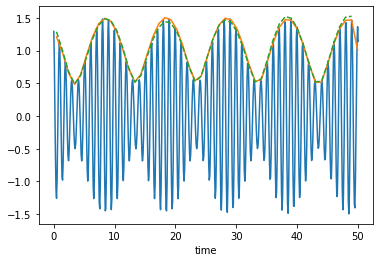

In [6]:
### equivalent to coarsen:
da.plot()
abs(2*da_harmo_win.isel(time=slice(n_win//2,None,n_win))).plot()
abs(2*da_harmo_nowin.isel(time=slice(n_win//2,None,n_win))).plot(linestyle="--")

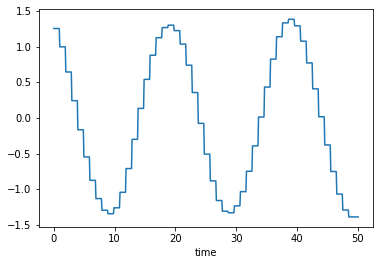

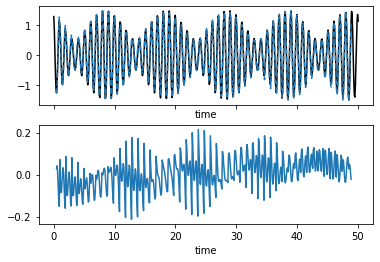

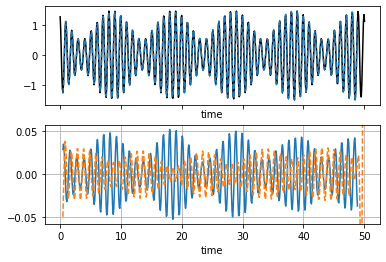

In [7]:
"""
Méthodes reconstruction:
    Méthode 1:
        Pour chaque fenêtre on multiplie la valeur par exp(j*omega*t) avec t vecteur temps réduit à la fenêtre
    Méthode 2:
        Interpolation linéaire entre chaque point 
        Rééchantillonage au temps de tps
        Multiplication en chaque point par exp(j*omega*t)
"""

# take harmonic with no windowing
da_harmo = (2*da*xr.ufuncs.exp(-1.j*omega*da.time)).coarsen(
                        time=n_win, boundary="trim", side="left").mean()

### Méthode 1
# une façon de procéder est d'utiliser interp1d avec method=nearest (un peu moche car commence par étendre le tableau des coefficient complexes)
# une autre façon est d'utiliser un groupby_bins sur le tableau de exp(1.j*omega*time). Pas fait ici
plt.figure()
da_harmo.interp(time=da.time, method="nearest", kwargs={"fill_value":"extrapolate"}).real.plot()

fig, axs = plt.subplots(2, 1, sharex=True)
ax = axs[0]
da.plot(ax=ax, color="k")
reco = (da_harmo.interp(time=da.time, method="nearest")*xr.ufuncs.exp(1.j*omega*da.time)).real
reco.plot(ax=ax, linestyle="--")
ax = axs[1]
(da-reco).plot(ax=ax)

# method 2: interp
fig, axs = plt.subplots(2, 1, sharex=True)
ax = axs[0]
da.plot(ax=ax, color="k")
reco = (da_harmo.interp(time=da.time, method="cubic")*xr.ufuncs.exp(1.j*omega*da.time)).real
reco.plot(ax=ax, linestyle="--")
ax = axs[1]
(da-reco).plot(ax=ax)
# also using harmonic extraction with windowing // emulate coarsening and re-interp
# it is a bit better except at the boundaries 
# (because I did not use a special treatment at boundaries, but this can be fixed easily)
limy = ax.get_ylim()
reci = (2*da_harmo_win.isel(time=slice(n_win//2,None,n_win)).interp(time=da.time, method="cubic")*xr.ufuncs.exp(1.j*omega*da.time)).real
(da-reci).plot(ax=ax, linestyle="--")
ax.set_ylim(limy)
ax.grid(True)